In [20]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="colorblind6",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 5
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    "Only CPR": load_data('../1/thermal_cpr', n_newest=NUM_SIMS),
    "Only Schur": load_data('../1/thermal_schur', n_newest=NUM_SIMS),
    "CPR and Schur only": load_data('../1/thermal_dynamic', n_newest=NUM_SIMS),
    "Many solvers": load_data("thermal_many_solvers", n_newest=NUM_SIMS),
    "Many solvers gp": load_data("thermal_many_solvers_gp", n_newest=NUM_SIMS),
    # "Random": load_data("thermal_random", n_newest=NUM_SIMS),
    # "Source location coldstart": load_data("thermal_coldstart_source_location", n_newest=NUM_SIMS),
    # "Source location warmstart": load_data("thermal_warmstart_source_location", n_newest=NUM_SIMS),
}

save_media_path = Path("media")
save_media_path.mkdir(exist_ok=True)

Loading data:
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_cpr_38.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_cpr_39.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_cpr_40.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_cpr_41.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_cpr_42.npy
Loading data:
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_schur_31.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_schur_32.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_schur_33.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_schur_34.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_schur_35.npy
Loading data:
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_dynamic_45.npy
/home/firedrake/solver_selector/examples/4/../1/performance/thermal_dynamic

Only CPR 285.6680772781372 7.313642501831055
Only Schur 156.98263511657714 0.8379859924316406
CPR and Schur only 140.60473160743715 15.617003917694092
Many solvers 501.66705188751223 141.48593640327454
Many solvers gp 208.78208708763123 72.8976321220398


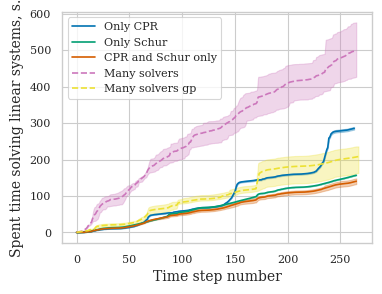

In [21]:
color_iter = -1
best_time = float("inf")
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    kwargs = dict()
    if name in ['Many solvers', 'Many solvers gp']:
        kwargs['linestyle'] = '--'

    plt.plot(x_space, mean, color=f"C{color_iter}", label=name, **kwargs)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend(loc='upper left')
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "experiment4_performance.pdf", bbox_inches="tight")

Many solvers
Many solvers gp


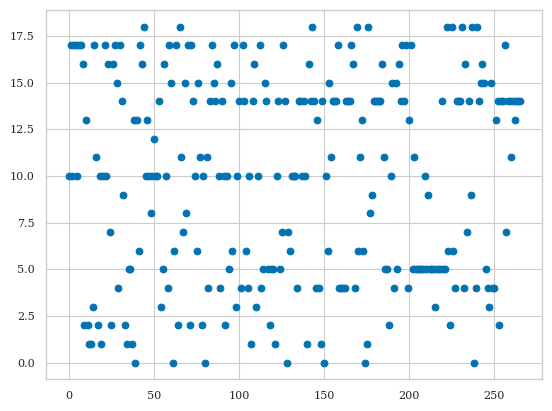

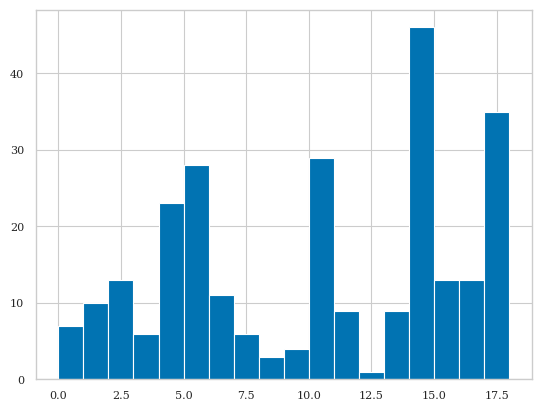

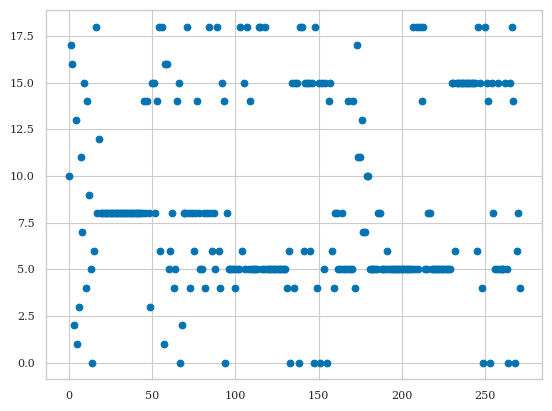

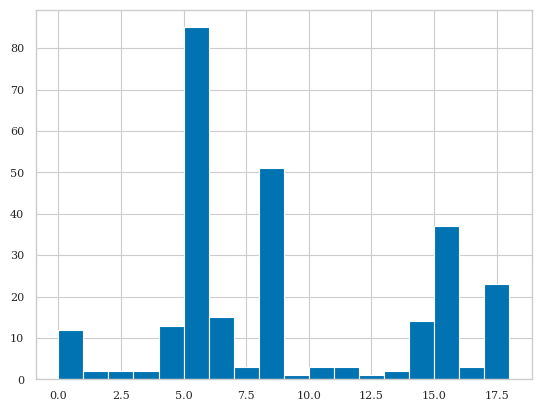

In [43]:
def cluster_solvers(solver_string: str):
    if solver_string == 'direct':
        return solver_string
    cpr = solver_string.find('cpr') != -1
    only_one_gmres = solver_string.rindex('gmres') == solver_string.index('gmres')
    if only_one_gmres:
        if cpr:
            return 'cpr'
        else:
            return 'schur'
    else:
        if cpr:
            return 'cpr - inner gmres'
        else:
            return 'schur - inner gmres'
        
def make_solver_colors(data: Sequence[SolverSelectionData]):
    def make_hashable(x: SolverSelectionData):
        return tuple(x.prediction.decision.subsolvers.items())

    from thermal_solvers import make_thermal_solver_space

    solver_space = make_thermal_solver_space("full")
    all_solvers = solver_space.get_all_solvers()

    subsolvers = list({make_hashable(x) for x in data})
    subsolvers_to_number = {subsolver: i for i, subsolver in enumerate(subsolvers)}

    solver_names = dict()
    for subsolvers, i in subsolvers_to_number.items():
        config = None
        tested = list(dict(subsolvers).values())
        for solver_template in all_solvers:
            expected = list(solver_template.subsolvers.values())
            if tested == expected:
                config = solver_space.config_from_decision(
                    solver_template.use_defaults(), optimized_only=True
                )
                break
        assert config is not None
        solver_names[i] = solver_space.format_config(config)

    data = [subsolvers_to_number[make_hashable(entry)] for entry in data]
    return data, solver_names
    # data = [cluster_solvers(solver_names[i]) for i in data]
    # cluster_names: list = np.unique(data).tolist()
    # data = [cluster_names.index(x) for x in data]
    # cluster_names = {i: x for i, x in enumerate(cluster_names)}
    # return data, cluster_names



def color_solvers(x, values, colors, names):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)

    names = names.copy()
    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        color = colors[i]
        args = {}
        if color in names:
            name = names.pop(color)
            # name = color
            args["label"] = name
        if color > 9:
            args["linestyle"] = "--"
        plt.plot(x_, val, linewidth=lw, c=f"C{color}", **args)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


for name, vals in data.items():
    if name not in ['Many solvers', 'Many solvers gp']:
        continue
    colors_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        solver_colors, solver_names = make_solver_colors(perf)
        colors_list.append(solver_colors)
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    print(name)
    plt.figure()
    plt.scatter(np.arange(len(solver_colors)), solver_colors)

    plt.figure()
    plt.hist(solver_colors, bins=18)

    # plt.figure(figsize=(6, 2))
    # color_solvers(sim_time_list[0], inlet_rate_list[0], colors_list[0], solver_names)
    # plt.ylabel("Source rate, $m^3 s^{-1}$.")
    # plt.xlabel(X_LABEL)
    # plt.yscale("log")
    # if save_media_path is not None:
    #     plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    # plt.show()

    # plt.figure(figsize=(6, 2))
    # plt.ylabel("Time step value, s.")
    # plt.xlabel(X_LABEL)
    # color_solvers(sim_time_list[0], time_step_list[0], colors_list[0], solver_names)
    # plt.yscale("log")
    # if save_media_path is not None:
    #     plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    # plt.show()
    # for i, name in solver_names.items():
    #     print(i, name, np.sum(np.array(solver_colors) == i))

Can we choose 2-3 best solvers from the bigger list of solvers?
evaluate cumulative performance prediction of pairs (or n solvers) after the simulation. 

Important thing the paper provides: the methology.
The amount of exploration is fixed for one solver. If we have more solvers, we need more exploration.

In [23]:
# from tqdm import tqdm
# import itertools
# from solver_selector.solver_selector import make_solver_selector
# from thermal_solvers import make_thermal_solver_space

# from thermal_solvers import DirectSolverNode, ForkNode


# solver_space = make_thermal_solver_space("full")
# # solver_space = ForkNode([DirectSolverNode(), DirectSolverNode(name='direct1')])
# all_solvers = solver_space.get_all_solvers()
# combinations_scores = {}
# for comb in tqdm(list(itertools.combinations(range(len(all_solvers)), 2))):
#     # if comb != (6, 8):
#     #     continue
#     print(comb)
#     solvers_to_use = all_solvers[comb[0]], all_solvers[comb[1]]
#     solver_selector = make_solver_selector(
#         solver_space,
#         params={
#             "exploration": 0,
#             "load_statistics_paths": get_newest_data_paths(
#                 "thermal_many_solvers_gp", n_newest=1
#             ),
#         },
#         solver_templates=solvers_to_use,
#     )
#     for performance_predictor in solver_selector.predictors:
#         assert performance_predictor.is_initialized
#     scores = []
#     for entry in data["Many solvers gp"][0]:
#         solver = solver_selector.select_solver(entry.prediction.context)
#         for performance_predictor in solver_selector.predictors:
#             assert performance_predictor.is_initialized
#         expected_score = solver.score
#         scores.append(expected_score)
#     combinations_scores[comb] = scores

In [24]:
# comb_total = {comb: sum(score) for comb, score in combinations_scores.items()}
# n_best = sorted(comb_total, key=comb_total.get, reverse=True)[:5]

# print("Best pairs of solvers:")
# for i, comb in enumerate(n_best):
#     plt.plot(combinations_scores[comb], label=comb)

#     print(i)
#     for id in comb:
#         default = all_solvers[id].use_defaults()
#         conf = solver_space.config_from_decision(decision=default, optimized_only=True)
#         print(solver_space.format_config(conf))
#     print()
# plt.legend()

In [38]:
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

solver_space = make_thermal_solver_space("full")
all_solvers = solver_space.get_all_solvers()

def find_best_pairs(sim_data: Sequence[SolverSelectionData], n_best=1):
    solver_selector = make_solver_selector(
        solver_space,
        params={
            "exploration": 0,
            # 'load_statistics': sim_data,
            'load_statistics': data['Many solvers gp'][-3],
        },
    )

    solver_scores = {}

    for i, performance_predictor in enumerate(solver_selector.predictors):
        print(i)
        assert performance_predictor.is_initialized
        scores = []
        for entry in sim_data:
            solver = performance_predictor.select_solver_parameters(
                entry.prediction.context
            )
            scores.append(solver.score)
        solver_scores[i] = np.array(scores)

    new_combinations_scores = {}

    for comb in itertools.combinations(range(len(all_solvers)), 2):
        s0_scores = solver_scores[comb[0]]
        s1_scores = solver_scores[comb[1]]
        new_combinations_scores[comb] = np.maximum(s0_scores, s1_scores)

    comb_total = {comb: sum(score) for comb, score in new_combinations_scores.items()}
    return sorted(comb_total, key=comb_total.get, reverse=True)[:n_best]

In [39]:
solver_space = make_thermal_solver_space("full")
all_solvers = solver_space.get_all_solvers()

results = []

for sim_data in data['Many solvers']:
    best_solvers = find_best_pairs(sim_data, n_best=1)
    results.append(best_solvers)

for best_solvers in results:
    for i, comb in enumerate(best_solvers):
        print(i)
        for id in comb:
            default = all_solvers[id].use_defaults()
            conf = solver_space.config_from_decision(decision=default, optimized_only=True)
            print(solver_space.format_config(conf))
        print()

Selecting from 19 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
4 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
7 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
8 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
9 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
10 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]

In [27]:
results = []

for sim_data in data['Many solvers gp'][:1]:
    best_solvers = find_best_pairs(sim_data, n_best=5)
    results.append(best_solvers)

for best_solvers in results:
    for i, comb in enumerate(best_solvers):
        print(i)
        for id in comb:
            default = all_solvers[id].use_defaults()
            conf = solver_space.config_from_decision(decision=default, optimized_only=True)
            print(solver_space.format_config(conf))
        print()

Selecting from 19 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
4 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
7 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
8 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
9 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
10 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]

In [28]:
def find_best_solver(sim_data: Sequence[SolverSelectionData], n_best=5):
    solver_selector = make_solver_selector(
        solver_space,
        params={
            "exploration": 0,
            'load_statistics': sim_data,
        },
    )

    solver_scores = {}

    for i, performance_predictor in enumerate(solver_selector.predictors):
        print(i)
        assert performance_predictor.is_initialized
        scores = []
        for entry in sim_data:
            solver = performance_predictor.select_solver_parameters(
                entry.prediction.context
            )
            scores.append(solver.score)
        solver_scores[i] = np.array(scores)

    solver_total = {solv: sum(score) for solv, score in solver_scores.items()}
    return sorted(solver_total, key=solver_total.get, reverse=True)[:n_best]

In [29]:
from contextlib import contextmanager
import sys
import os

@contextmanager
def stdout_redirected():
    save_stdout = sys.stdout
    with open(os.devnull, 'w') as f:
        sys.stdout = f
        try:
            yield None
        finally:
            sys.stdout = save_stdout

In [30]:
from data_scripts import make_num_linear_iters
from tqdm import tqdm
results = []



for sim_data in tqdm(data['Many solvers gp']):
    with stdout_redirected():
        best_solvers = find_best_solver(sim_data, n_best=10)
        results.append(best_solvers)

for best_solvers in results:
    for i, comb in enumerate(best_solvers):
        default = all_solvers[i].use_defaults()
        conf = solver_space.config_from_decision(decision=default, optimized_only=True)
        print(i, solver_space.format_config(conf))
    print()


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
4 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
7 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
8 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
9 fgmres - schur_cd [primary - amg, secondary - amg, method=full]

0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], 

In [163]:
# gb_data = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_10.npy', allow_pickle=True).tolist()
gp_data = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_9.npy', allow_pickle=True).tolist()

gp = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_9_metrics.npy', allow_pickle=True).item()
# gb = np.load('/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_10_metrics.npy', allow_pickle=True).item()

colors, _ = make_solver_colors(gp_data)
colors = np.array(colors)

values, count = np.unique(colors, return_counts=True)
argsort = np.argsort(count)[::-1]
count = count[argsort]
values = values[argsort]
most_common_solver = colors == values[5]

timesteps_where_used = np.where(most_common_solver)[0]

gp_update = np.array(gp['update_selector_times'])[most_common_solver]
gp_select = np.array(gp['select_solver_times'])[most_common_solver]

# # gb_update = gb['update_selector_times']
# # gb_select = gb['select_solver_times']

In [164]:
timesteps_where_used

array([ 11,  45,  47,  53,  65,  77,  93, 109, 156, 168, 171, 212, 252,
       267])

In [165]:

# from data_scripts import make_solve_linear_system_time, sum_per_time_step

# t_solve = sum_per_time_step(make_solve_linear_system_time(gb_data, converged=False), gb_data, converged=False)

echo "Hello line 1" \
    "Hello line 2" \
    "Hello line 3"

In [ ]:
echo "Hello line 1" \
    # "Hello line 2" \
    "Hello line 3"

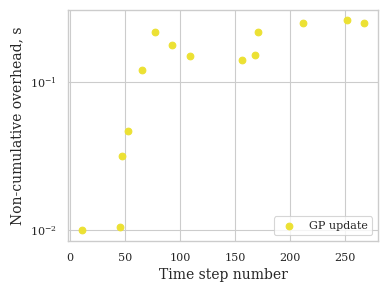

In [166]:
plt.figure(figsize=(4, 3))
# plt.plot(gp_select, label='gp select', color='C0', linestyle='--')
# plt.plot(gb_update, label='Heuristic update', color='C3')
plt.scatter(timesteps_where_used, gp_update, label='GP update', color='C4')
# plt.plot(gb_select, label='eps select', color='C1', linestyle='--')
# plt.plot(t_solve, label='3', color='C3')
plt.yscale('log')
plt.legend()

plt.ylabel('Non-cumulative overhead, s')
plt.xlabel('Time step number')

if save_media_path is not None:
    plt.savefig(save_media_path / "overheads.pdf", bbox_inches="tight")

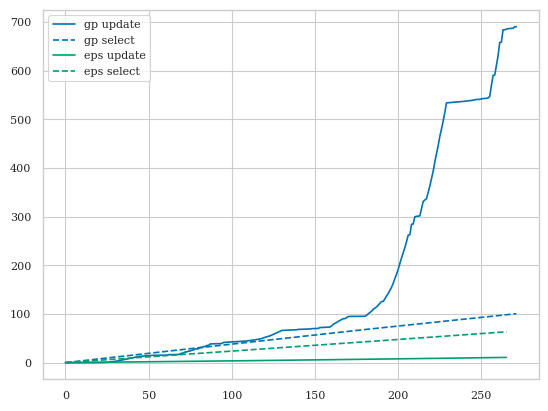

In [ ]:
plt.plot(np.cumsum(gp_update), label='gp update', color='C0')
plt.plot(np.cumsum(gp_select), label='gp select', color='C0', linestyle='--')
plt.plot(np.cumsum(gb_update), label='eps update', color='C1')
plt.plot(np.cumsum(gb_select), label='eps select', color='C1', linestyle='--')
# plt.yscale('log')
plt.legend()

In [ ]:
from tqdm import tqdm
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

from thermal_solvers import DirectSolverNode, ForkNode


solver_space = make_thermal_solver_space("full")
# solver_space = ForkNode([DirectSolverNode(), DirectSolverNode(name='direct1')])
all_solvers = solver_space.get_all_solvers()

solver_selector = make_solver_selector(
    solver_space,
    params={
        "exploration": 0,
        "load_statistics_paths": get_newest_data_paths(
            "thermal_many_solvers", n_newest=1
        ),
    },
)

solver_scores = {}

ids = []

for entry in data["Many solvers"][0]:
    solver = solver_selector.select_solver(context=entry.prediction.context)
    idx = solver_selector._get_solver_idx(solver.decision)
    print(idx)
    ids.append(idx)

Selecting from 19 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
4 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
7 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
8 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
9 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
10 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]

In [ ]:
res = np.bincount(ids)
for i in range(18):
    print(i, res[i])

0 0
1 6
2 0
3 0
4 0
5 0
6 1
7 2
8 0
9 48
10 7
11 100
12 0
13 61
14 1
15 21
16 9
17 10


In [ ]:
np.sum(res > 5)

8